In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_embassy = pd.read_csv("../data/ulaanbaatar-us embassy-air-quality.csv")
df_naran = pd.read_csv("../data/urgakh-naran-air-quality.csv")
df_100 = pd.read_csv("../data/100-ail-air-quality.csv")
df_misheel = pd.read_csv("../data/misheel-expo-air-quality.csv")

In [3]:
df_misheel.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co'], dtype='object')

In [4]:
dataframes = [df_embassy, df_naran, df_100, df_misheel]

#Location names
locations = ['US Embassy', 'Naran Mall', '100 Ail', 'Misheel Expo'] 
#Pollutant names
pollutants = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']

In [5]:
def data_cleaner(df):
    #Remove the empty spaces from the columns
    df.columns = df.columns.str.strip()
    #Change empty data into Nan
    df = df.replace(to_replace = " ", value=np.nan)
    #Change dates to same format
    df['date'] = pd.to_datetime(df['date'])
    #Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    #Remove rows with only date data
    df = df.dropna(subset=pollutants, how='all')
    
    for col in pollutants:
        #Ensure data is in float format
        df[col] = pd.to_numeric(df[col], errors='coerce')
        #If data is more than 5 times of last 14 days median replace with NaN
        df.loc[df[col] > df[col].rolling(14, min_periods=2).median().shift(1) * 5, col] = np.nan
        #Fill the missing data with rolling median
        df[col] = df[col].fillna(df[col].rolling(7, min_periods=1).median())

    
    return df

In [6]:
cleaned_dfs = []
for df in dataframes:
    df_clean = data_cleaner(df)
    cleaned_dfs.append(df_clean)

In [7]:
cleaned_dfs[1].head(10)

,date,pm25,pm10,o3,no2,so2,co
0,2014-09-15,NaN,NaN,NaN,12.0,3.0,3.0
1,2014-09-16,NaN,69.0,14.0,5.0,5.0,3.0
2,2014-09-17,NaN,53.0,14.0,8.5,4.0,3.0
3,2014-10-22,NaN,61.0,10.0,7.0,2.0,1.0
4,2014-10-23,NaN,3.0,15.0,9.0,12.0,3.0
5,2014-10-24,NaN,4.0,14.0,8.0,4.0,3.0
6,2014-11-02,NaN,28.5,5.0,24.0,12.0,4.0
7,2014-11-03,NaN,109.0,2.0,27.0,10.0,9.0
8,2014-11-04,NaN,126.0,7.5,16.5,11.0,3.5
9,2014-11-09,NaN,56.5,7.0,10.0,1.0,3.0


In [8]:
combined = []

for i, df in enumerate(cleaned_dfs):
    df = df.copy()
    location_name = locations[i] if i < len(locations) else f'Location {i+1}'
    df['location'] = location_name
    combined.append(df)

# Merge all into one DataFrame
df_all = pd.concat(combined, ignore_index=True)

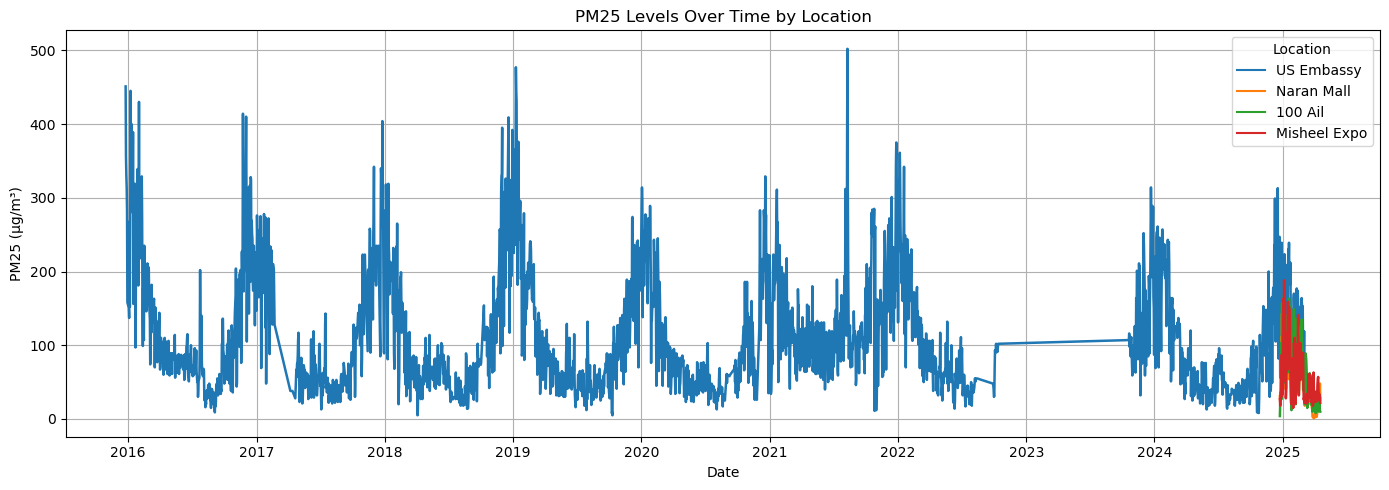

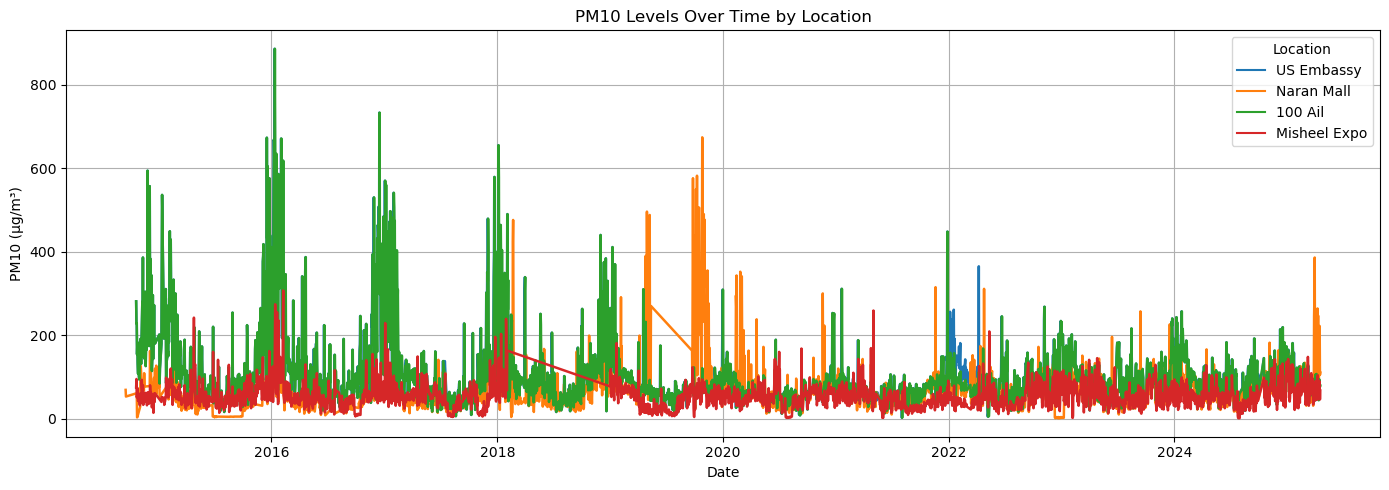

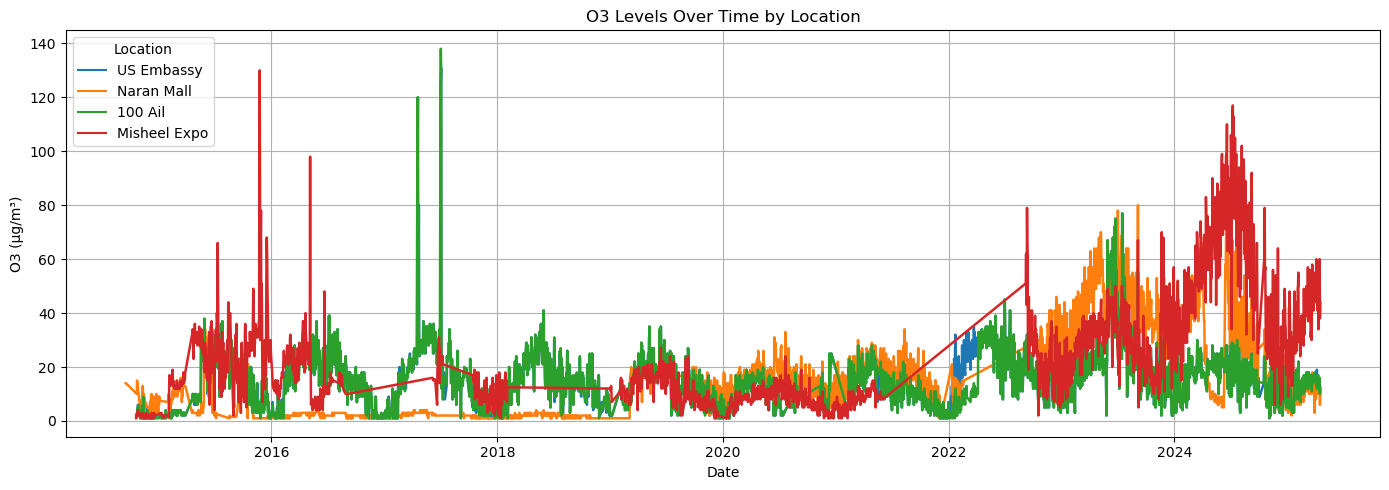

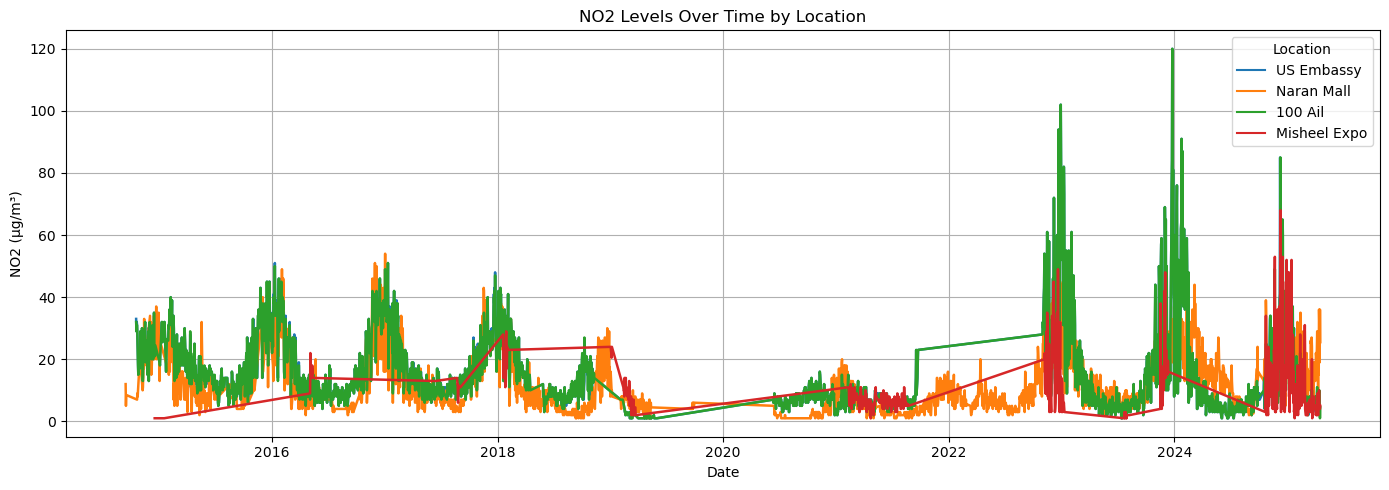

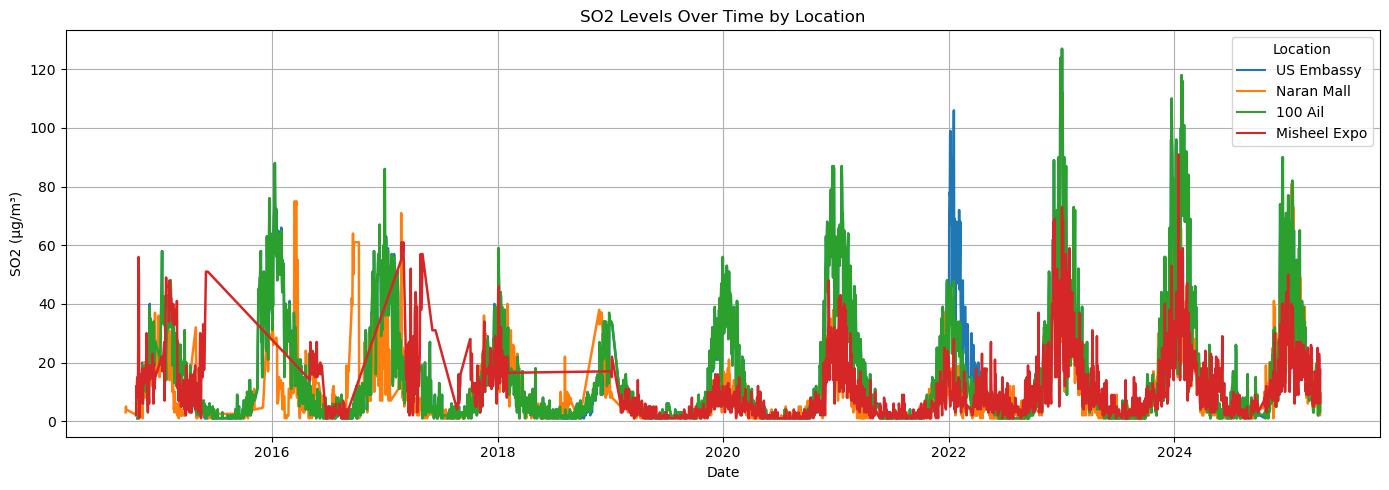

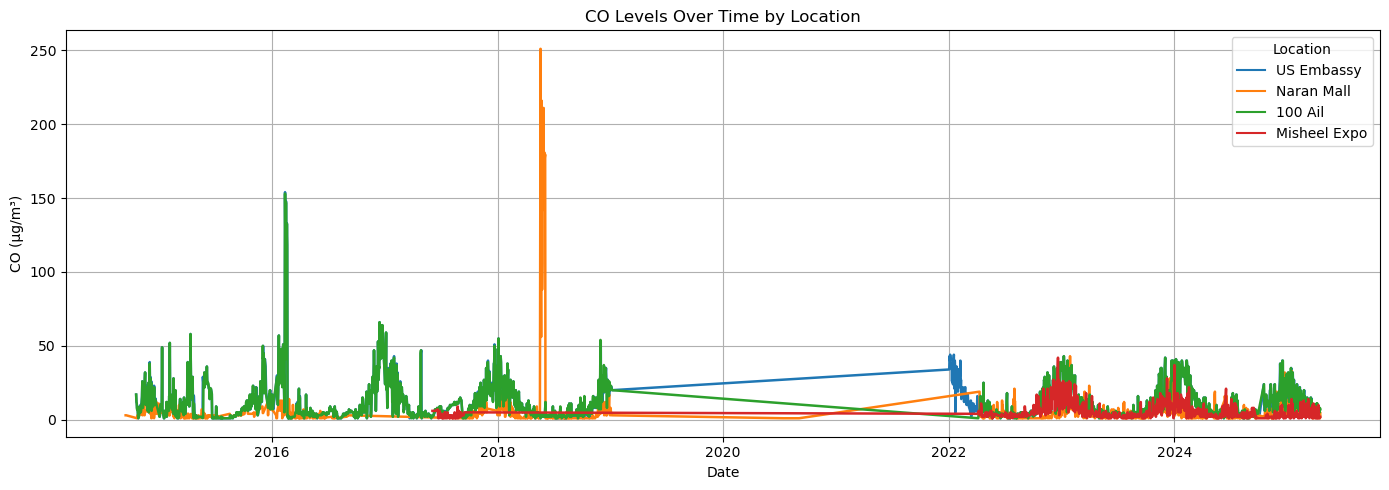

In [9]:
for pollutant in pollutants:
    if pollutant in df_all.columns:
        plt.figure(figsize=(14, 5))
        sns.lineplot(data=df_all, x='date', y=pollutant, hue='location', linewidth=1.8)
        plt.title(f'{pollutant.upper()} Levels Over Time by Location')
        plt.xlabel('Date')
        plt.ylabel(f'{pollutant.upper()} (μg/m³)')
        plt.legend(title='Location')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [47]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.metrics import RootMeanSquaredError

In [ ]:
#Create new dataframe for the LSTM model to train on pm10
df_pm10 = cleaned_dfs[3][['date', 'pm10']].dropna()
df_pm10 = df_pm10.sort_values('date')

# Normalize PM10 values
data = df_pm10['pm10'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)



In [49]:
# Function to create sequence list and next value list of that sequence 
def create_sequences(data, seq_len):
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(x), np.array(y)

In [50]:
#Create sequence with 30 days window
seq_len = 30
x, y = create_sequences(data_scaled, seq_len)

In [51]:
#Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [57]:
#Create the model
model = Sequential()
#LSTM layers
model.add(LSTM(64, return_sequences=True, input_shape=(seq_len, 1)))
model.add(LSTM(64, return_sequences=False))

#Final layer to predict the next value
model.add(Dense(1))

model.summary()
model.compile(optimizer='adam', loss='mae')

C:\conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 30, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
training = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0677 - val_loss: 0.0612
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0522 - val_loss: 0.0639
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0552 - val_loss: 0.0606
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0519 - val_loss: 0.0579
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0518 - val_loss: 0.0572
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0503 - val_loss: 0.0580
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0505 - val_loss: 0.0558
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0470 - val_loss: 0.0539
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0495 - val_loss: 0.0531
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0483 - val_loss: 0.0552
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0490 - val_loss: 0.0531
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0

In [59]:
#Prediction for the test data
y_pred = model.predict(x_test)

#Inverse the scaling for both test and predidction values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


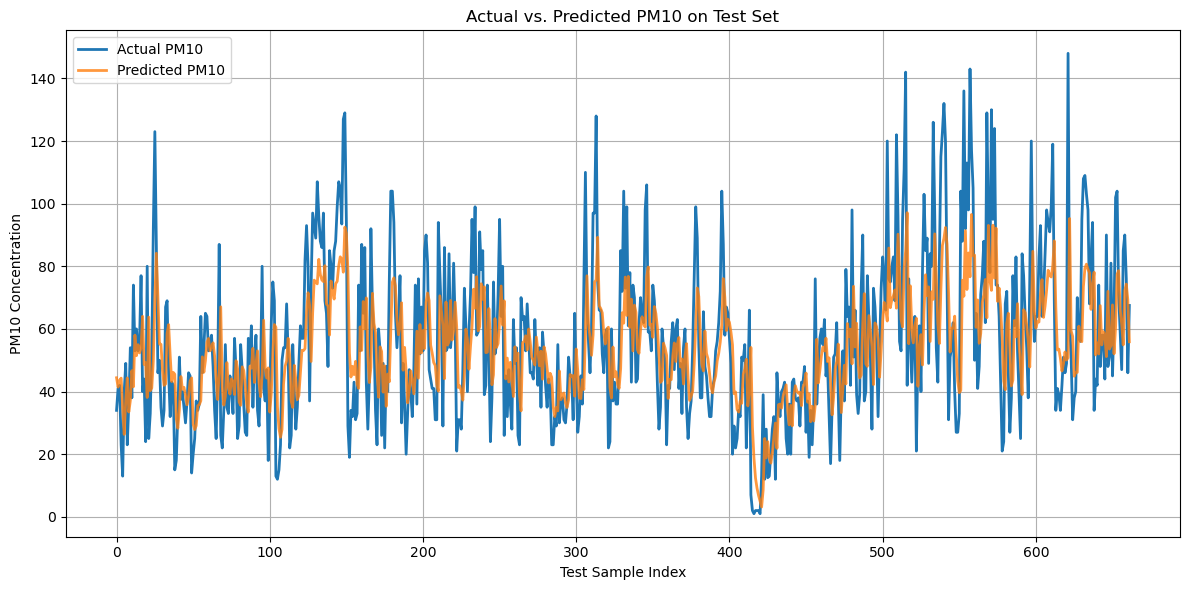

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual PM10', linewidth=2)
plt.plot(y_pred_inv, label='Predicted PM10', linewidth=2, alpha=0.8)
plt.title('Actual vs. Predicted PM10 on Test Set')
plt.xlabel('Test Sample Index')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()